In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as const
import astropy.constants as aconst
import time
from pycbc.filter import make_frequency_series
from calcwf import *

We can investigate eccentric harmonics in TEOBResumS using a qtransform.

In [2]:
# df/dt equation involving eccentricity
def df_dt_eqn(f, e, m1, m2):
    consts = 384*np.pi/(5*const.c**5)
    P = 2/f
    P_term = (2*np.pi*const.G)**(5/3)/P**(11/3)
    m1 *= aconst.M_sun.value
    m2 *= aconst.M_sun.value
    m_term = m1*m2/(m1+m2)**(1/3)
    e_term = (1+73*e**2/24+37*e**4/96)/(1-e**2)**(7/2)
    return consts*P_term*m_term*e_term

# Evolve df/dt eqn over discrete time steps
def df_dt_evolve(f_low, f_high, df, e_start, M, q, t_0):

    # ICs
    ts = [t_0]
    fs = [f_low]
    es = [e_start]
    m1, m2 = m1_m2_from_M_q(M, q)

    # Evolve until f_high
    while fs[-1] < f_high:

        # Increment parameters
        es.append(shifted_e_approx(fs[-1]+df, fs[-1], es[-1]))
        dt_df = 1/df_dt_eqn(fs[-1], es[-1], m1, m2)
        ts.append(ts[-1] + dt_df*df)
        fs.append(fs[-1] + df)

    # Return thinned arrays
    return np.array(ts)[::100], np.array(fs)[::100]

In [3]:
# Gen wf and qtransform
h = gen_wf(10, 0.1, chirp2total(10,2), 2, 1024, 'TEOBResumS')
h_q_times, h_q_freqs, h_q_plane = h.real().qtransform(1/512, logfsteps=300, qrange=(30,30), frange=(3, 100))
h_q_amp = h_q_plane**0.5

# Normalise amplitude at each time
h_q_amp /= np.max(h_q_amp, axis=0)

# Get evolution of f_gw
t_arr, f_gw = df_dt_evolve(10, 60, 0.001, 0.1, chirp2total(10,2), 2, h.sample_times[0])
t_arr += 0.3 # fudge factor

(-10.0, 0.0)

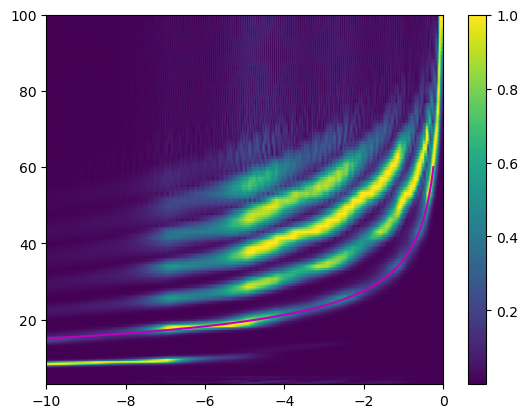

In [4]:
# Make qtransform plot
plt.pcolormesh(h_q_times, h_q_freqs, h_q_amp)
plt.colorbar()

# Plot frequency track
plt.plot(t_arr, f_gw, c='m')

# Plot formatting
plt.ylim(3,100)
plt.xlim(-10, 0)

The magenta line here tracks the frequency evolution of our h0 harmonic. Now, let's work out the frequencies of our other harmonics using the frequency of apsidal advance (denoted $f_\textrm{peri}$ here).

In [5]:
# Gets orbital frequency from gravitational wave frequency
def f_orb(f_gw):
    return f_gw/2

# Gets apsidal advance frequency from gravitational wave frequency
def f_peri(f_gw, f_low, ecc, M):
    P_orb = 1/f_orb(f_gw)
    e = shifted_e(f_gw, f_low, ecc)
    peri_advance_per_orb = peri_advance_orbit(P_orb, e, M*aconst.M_sun.value)
    P_peri = P_orb*2*np.pi/peri_advance_per_orb
    return 1/P_peri

Now we can test whether the frequencies in the above plot, or simple integer multiples of the orbital frequency fit the harmonics we see in the qtransform.

In [6]:
# Get how many multiples of f_peri for harmonic k
def f_peri_multiple(k):
    if k < 5:
        return int((k+1)/2)*(2*(k%2)-1)
    else:
        return k-2

# Frequencies of harmonics assuming integer multiples of orbital freq
def int_harm_freqs(f_gws, n, *args):

    # Calculate frequencies
    freqs = []
    for i in range(n):
        if i != 2:
            freqs.append(i*f_gws/2)

    return freqs

# Frequencies of harmonics using apsidal advance frequency
def peri_harm_freqs(f_gws, n, f_low, ecc, M):

    # Calculate frequency components
    f_orbs = f_orb(f_gws)
    f_peris = f_peri(f_gws, f_low, ecc, M)

    # Calculate frequency for each harmonic
    freqs = []
    for k in range(n):
        if k != 0:
            peri_mult = f_peri_multiple(k)
            f_harms = (peri_mult+2)*f_orbs - peri_mult*f_peris
            freqs.append(f_harms)

    return freqs

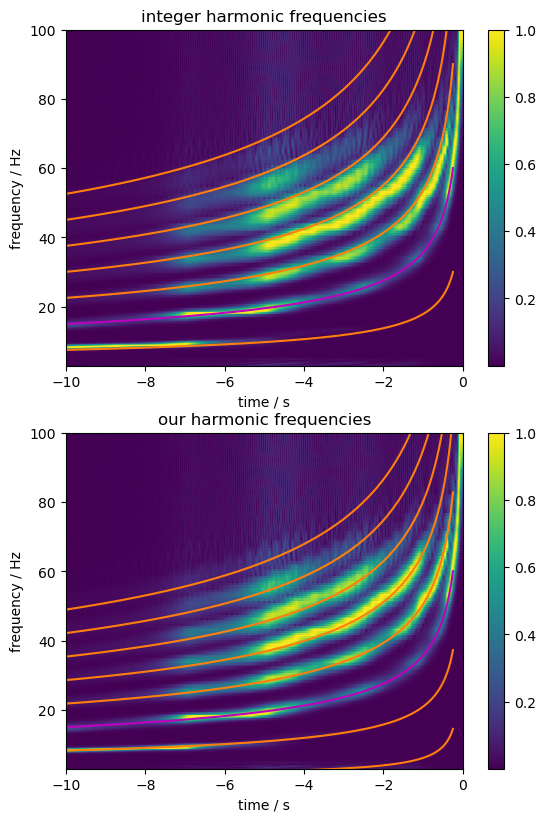

In [7]:
# Subplot settings
harm_funcs = [int_harm_freqs, peri_harm_freqs]
titles = ['integer harmonic frequencies', 'our harmonic frequencies']

# Figure with two subplots
plt.figure(figsize=(6.4,4.8*2))
for i in range(2):
    plt.subplot(2,1,i+1)

    # Make qtransform plot
    plt.pcolormesh(h_q_times, h_q_freqs, h_q_amp)
    plt.colorbar()

    # Plot frequency track
    plt.plot(t_arr, f_gw, c='m')
    
    # Plot harmonic frequency predictions
    harm_freqs = harm_funcs[i](f_gw, 8, 10, 0.1, chirp2total(10, 2))
    for harm_freq in harm_freqs:
        plt.plot(t_arr, harm_freq, c='C1')
    
    # Plot formatting
    plt.title(titles[i])
    plt.ylim(3,100)
    plt.xlim(-10, 0)
    plt.xlabel('time / s')
    plt.ylabel('frequency / Hz')

Clearly our harmonic frequencies fit the qtransform plot far better.

Can we find the harmonic with $0f_\textrm{orb} + 2f_\textrm{peri}$? Using the literature's scaling, this should not exist.

(-10.0, 0.0)

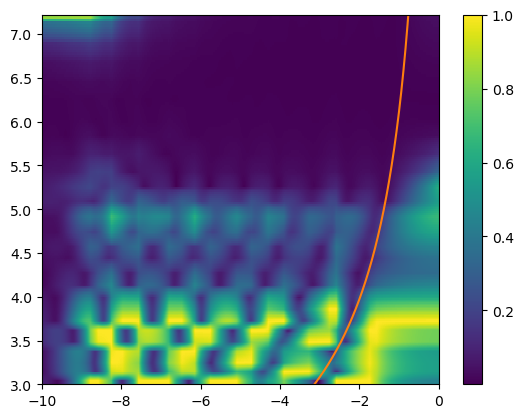

In [9]:
# Gen wf and qtransform
h = gen_wf(10, 0.1, chirp2total(10,2), 2, 1024, 'TEOBResumS')
h_q_times2, h_q_freqs2, h_q_plane2 = h.real().qtransform(1/512, logfsteps=1000, qrange=(30,30), frange=(3, 200))
h_q_amp2 = h_q_plane2**0.5

# Cut at low freq, and normalise
h_q_freqs_low = h_q_freqs2[:210]
h_q_amp_low = h_q_amp2[:210]
h_q_amp_low /= np.max(h_q_amp_low, axis=0)

# Plot cut qtransform
plt.pcolormesh(h_q_times2, h_q_freqs_low, h_q_amp_low)
plt.colorbar()

# Plot frequency harmonics
harm_freqs = peri_harm_freqs(f_gw, 8, 10, 0.1, chirp2total(10, 2))
for harm_freq in harm_freqs:
    plt.plot(t_arr, harm_freq, c='C1')

# Plot formatting
plt.ylim(h_q_freqs_low[0], h_q_freqs_low[-1])
plt.xlim(-10, 0)

Whilst there is power in the correct general area, cannot say from this plot that there is definitively something there. Have tried adjusting qrange settings however am unable to pull anything significant out.

Let's try with a simple fourier transform instead.

In [10]:
s = gen_wf(5, 0.2, chirp2total(10, 2), 2, 1024, 'TEOBResumS')
s_peri = f_peri(5, 5, 0.2, chirp2total(10, 2))
print(s_peri)

0.12016776137530934


Text(0.5, 0, 'Frequency / Hz')

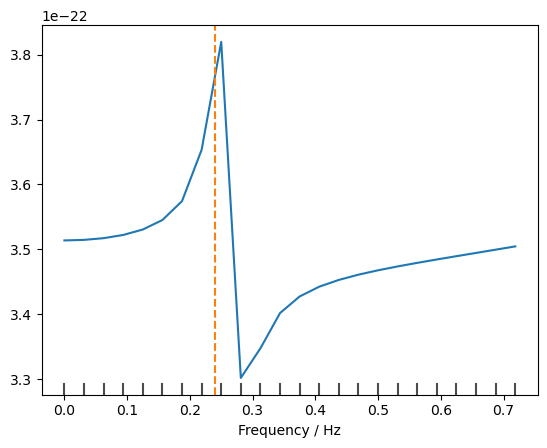

In [16]:
s_f = make_frequency_series(s.real()[0:1024*32])
plt.plot(s_f.sample_frequencies[0:24], abs(s_f)[0:24])
plt.axvline(s_peri*2, c='C1', ls='dashed')
for freq in s_f.sample_frequencies[0:24]:
    plt.axvline(freq, 0, 0.03, c='k', alpha=0.7)
plt.xlabel('Frequency / Hz')

For these parameters, f_peri is roughly 0.12 Hz, meaning the harmonic we are looking for should be at ~0.25Hz, matching what we see here. To be completely sure, we should try an SVD with a high sampling rate, number of training waveforms, and eccentricity. Analysing this in h4_search_SVD.ipynb.

We can make a plot here of how the harmonic frequencies evolve with gravitational wave frequency ($f_\textrm{gw} = 2f_\textrm{orb}$).

In [64]:
# Find ISCO frequency from total mass
def f_ISCO(M):

    f_ISCO = const.c**3/(6*np.sqrt(6)*np.pi*const.G*M*aconst.M_sun.value)

    return f_ISCO

In [101]:
# Parameters
harmonics = np.arange(8)
ecc = 0.2 # defined at f_low
M = chirp2total(24, 2)
f_low = 0
f_high = f_ISCO(M)
fs = np.linspace(f_low, f_high, 1001)[1:]

In [102]:
# Draw frequency evolution of harmonics
def plot_f_harms(ax, ks, f_gws):

    # Get component of frequencies
    f_orbs = f_orb(f_gws)
    f_peris = f_peri(f_gws, f_low, ecc, M)

    # Add and plot frequencies for each harmonic
    for k in ks:
        peri_mult = f_peri_multiple(k)
        f_harms = (peri_mult+2)*f_orbs - peri_mult*f_peris
        ax.plot(f_gws, f_harms/f_orbs, label=f'h{k}')
        label_x_pos = f_gws[-1] + (f_gws[-1]-f_gws[0])/100
        plt.text(label_x_pos, f_harms[-1]/f_orbs[-1], f'$h_{k}$', va='center')

# Plots a dashed line at every integer on the y axis
def plot_int_lines(ax, n):
    if n < 5:
        n = 5
    ints = np.arange(1, n)
    for y_pos in ints:
        plt.axhline(y_pos, c='k', ls='dashed', alpha=0.5, zorder=-1)

(0.0, 5.0)

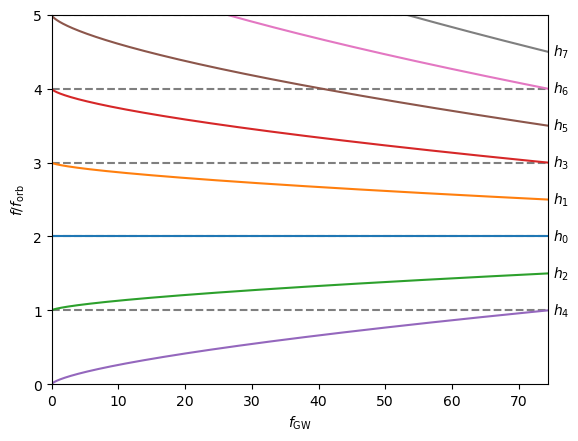

In [103]:
# Make plot
plot_f_harms(plt.gca(), harmonics, fs)
plot_int_lines(plt.gca(), len(harmonics))
plt.xlabel('$f_\mathrm{GW}$')
plt.ylabel('$f$/$f_\mathrm{orb}$')
plt.xlim(f_low, f_high)
plt.ylim(0,5)